In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

In [2]:
# Data paths
case = ''
data_path_taker = 'output_data/btes_base_case_orca_{0}price_taker/btes_output_price_taker_base_BTES_costsx#COST.pickle'.format(case)
data_path_maker = 'output_data/btes_base_case_orca{0}/btes_output_BTES_costsx#COST.pickle'.format(case)

# Prices to scan
prices = ['0p01', '0p1', '0p25','0p5', '0p75', '0p765', '0p77', '0p9','1p0']

# Colors
colors = {'price_taker': '#DE3163', 'price_maker': '#00008B'}
color_shades = {'price_taker': ['#f091ac', '#e54573', '#c0063b'], 'price_maker': ['#9c9cea', '#5757d3', '#04049d']}

In [3]:
def get_btes_investment(component_results):
    """
    Get capital expenditure for BTES, i.e. sum of discharge, charge and energy store investment
    """
    btes_investment = 0
    for comp in [('Link','BTES_charger'), ('Link','BTES_discharger'), ('Store','granite')]:
        btes_investment += component_results[component_results.index == comp]['Capital Expenditure [$]'].values[0]
    return btes_investment

In [4]:
def read_output_file(filename):
    """
    Read file results
    """
    with open(filename, 'rb') as f:
        data = pickle.load(f)

        # Get cost from file name
        btes_cost = (filename.split('_')[-1].split('.')[0])

        # Get results from file
        case_data = data['case results']
        comp_results = data['component results']
        time_results = data['time results']

        return case_data, comp_results, time_results, btes_cost
    

In [5]:
def plot_bars_maker_taker(x,y, xlabel, ylabel, title=None, split_bars=False):
    """
    Plot bar chart for price maker and price taker
    """
    plt.figure()
    # Convert x values to str
    x_ticks = np.arange(len(x))
    multiplier = 0
    width =  0.25
    for run,cost in y.items():
        offset = width * (multiplier+0.5)
        if not split_bars:
            # plt.bar(x_ticks+offset, cost, color=colors[run], width=width, label=run)
            # Plot as points
            plt.plot(x, cost, 'o', color=colors[run], label=run)
        else:
            for iv,vals in enumerate(cost):
                bottom = 0
                for j,nums in enumerate(vals):
                    plt.bar(x_ticks[iv]+offset, nums/sum(vals), width=width, label=run, bottom=bottom, 
                            color=color_shades[run][j])
                    bottom += nums/sum(vals)
            plt.xticks(x_ticks+width, x)

        multiplier += 1

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title if title else '')
    # Get unique legend entries
    if not split_bars:
        handles, labels = plt.gca().get_legend_handles_labels()
        labels = [label.replace('_', ' ').capitalize() for label in labels]
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
    else:
        # Custom legend
        legend_elements = [
            Patch(facecolor=colors['price_taker'], label='Price taker'),
            Patch(facecolor=colors['price_maker'], label='Price maker'),
            Patch(facecolor='#747474', label='Storage'),
            Patch(facecolor='#b0b0b0', label='Charger'),
            Patch(facecolor='#e3e3e3', label='Discharger'),
        ]

        # Put legend outside of plot
        plt.legend(handles=legend_elements, bbox_to_anchor=(1, 0.5))

    # Save figure
    plt.savefig('figures/btes_{0}.jpg'.format(title.replace(' ','_').replace(',','').lower()), bbox_inches='tight', dpi=500)


In [6]:
def plot_curve_maker_taker(var, run, xlabel, ylabel, title=None):
    """
    Plot curve for price maker and price taker
    """
    plt.plot(var, label=run)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title if title else '')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1, 0.5))
    # Save figure
    if not os.path.exists('figures'):
        os.makedirs('figures')
    plt.savefig('figures/btes_{0}.png'.format(title.replace(' ','_').replace(',','').lower()), bbox_inches='tight')

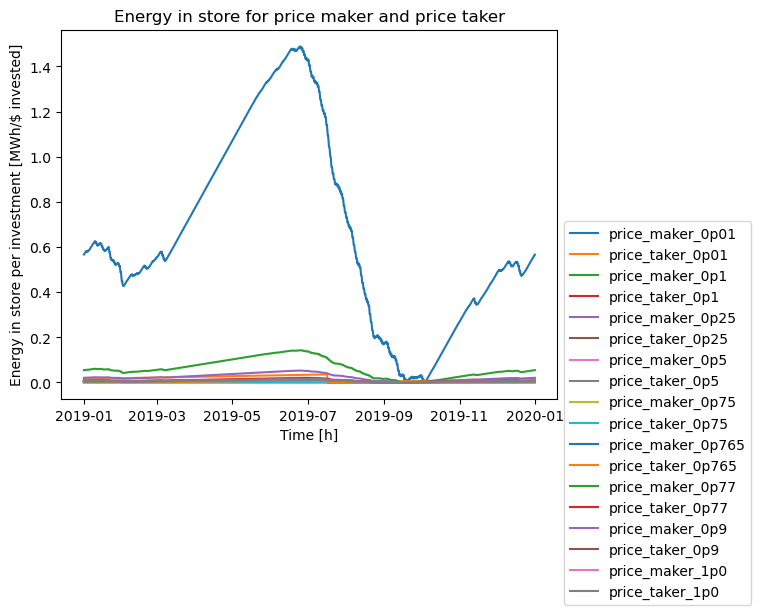

In [7]:
# Collect results
rev_per_inv = {'price_maker': [], 'price_taker': []}
duration = {'price_maker': [], 'price_taker': []}
inv = {'price_maker': [], 'price_taker': []}
energy_in_store = {'price_maker': [], 'price_taker': []}
# Loop over prices in descending order
for price in prices:
    # Get results
    for run in ['maker', 'taker']:
        case_res, comp_res, time_res, btes_cost = read_output_file(data_path_maker.replace('#COST', str(price)) if run == 'maker' else data_path_taker.replace('#COST', str(price)))

        # Calculate revenue per investment
        btes_investment = get_btes_investment(comp_res)
        if run =='maker':
            no_btes_file = 'output_data/btes_base_case_orca_no_btes/btes_output_no_btes.pickle'
            cost_no_btes = read_output_file(no_btes_file)[0]['objective [$]'].values[-1]
            cost = case_res['objective [$]'].values[-1] - cost_no_btes
        else:
            cost = case_res['objective [$]'].values[-1]
        cost = (-1) * cost / btes_investment
        rev_per_inv['price_maker' if run == 'maker' else 'price_taker'].append(cost)

        # Calculate duration
        granite = comp_res[comp_res.index == ('Store', 'granite')]
        discharger = comp_res[comp_res.index == ('Link', 'BTES_discharger')]
        charger = comp_res[comp_res.index == ('Link', 'BTES_charger')]

        granite_opt_cap = granite['Optimal Capacity [MW]'].values[0]
        discharger_opt_cap = discharger['Optimal Capacity [MW]'].values[0] 
        dur = granite_opt_cap / discharger_opt_cap

        duration['price_maker' if run == 'maker' else 'price_taker'].append(dur)

        # Get investment
        inv['price_maker' if run == 'maker' else 'price_taker'].append([discharger['Capital Expenditure [$]'].values[0], charger['Capital Expenditure [$]'].values[0], granite['Capital Expenditure [$]'].values[0]])

        # Get energy in store
        plot_curve_maker_taker(time_res['granite e']/btes_investment, ('price_maker' if run == 'maker' else 'price_taker')+'_'+price, 'Time [h]', 'Energy in store per investment [MWh/$ invested]', 'Energy in store for price maker and price taker')

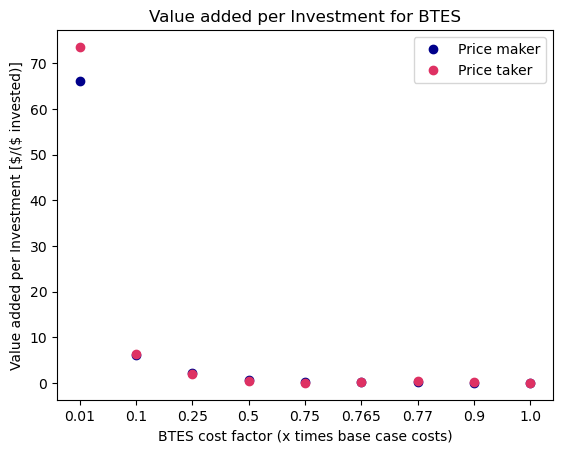

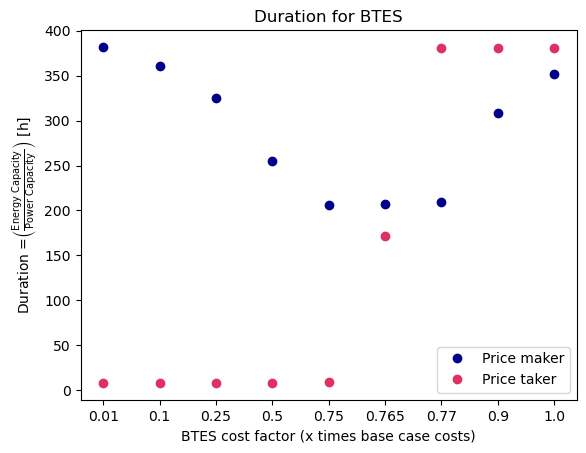

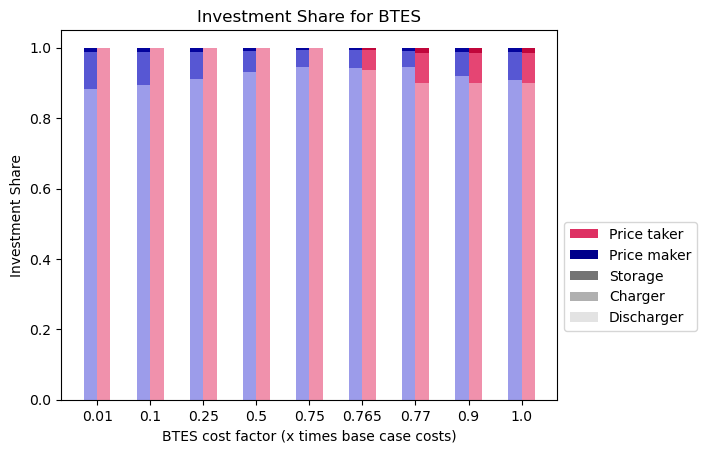

In [8]:
# Replace p with . in prices
prices = [price.replace('p', '.') for price in prices]
# Plot revenue per investment
plot_bars_maker_taker(prices, rev_per_inv, 'BTES cost factor (x times base case costs)', 'Value added per Investment [$/(\$ invested)]', 'Value added per Investment for BTES')
# Plot duration
plot_bars_maker_taker(prices, duration, 'BTES cost factor (x times base case costs)', r'Duration =$\left( \frac{\mathrm{Energy \ Capacity}}{\mathrm{Power \ Capacity}} \right)$ [h]', 'Duration for BTES')
# Plot investment share
plot_bars_maker_taker(prices, inv, 'BTES cost factor (x times base case costs)', 'Investment Share', 'Investment Share for BTES', split_bars=True)